# Layout

Notebook plan (next week):
Clustering documents
hierarchical clustering
k-means clustering
visualization of methods of cluster identification
topic modeling with many/few topics (adjust alpha, beta)
topic model visualization
topic model interpretation/statistics
matrix of topic similarity corpora
topic model extension - correlated, dynamic, author

+ Opening
+ packages
    + scikit-learn
    + gensim
+ Introduce ML
+ Training
    + Use sklearn dataset examples
+ Extraction
    + Probabilistic models
    + Deterministic models
    + stop lists
    + cleaning
    + Performance
    + [sklearn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster)
        + [Tfidf](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
        + [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
        + Hierarchical
    + [gensim](http://radimrehurek.com/gensim/apiref.html)
        + [LDA](https://radimrehurek.com/gensim/models/ldamodel.html)
            + Expansions on LDA
        + [word2vec](https://radimrehurek.com/gensim/models/word2vec.html)
        + Doc2Vec
    + Implement our own models
        + regressions

# Week 3 - Clustering

Intro stuff ...

For this notebook we will be using the following packages

In [1]:
#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition


import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import json

# Intro

intro stuff ...

# Getting our corpuses

To start with we can get a dataset to work on from sklearn

In [2]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train')
print(dir(newsgroups))

['DESCR', 'data', 'description', 'filenames', 'target', 'target_names']


We can get the categories with `target_names` or the actual files with `filenames`

In [3]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames

lets reduce our dataset for this analysis, drop some of the extraneous information and convert it into a DataFrame

In [4]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'])
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,category,source_file,text
0,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,"\tIn certain Apple 13"" RGB monitors there has ..."
1,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,Does anyone know how to reach Micron? I am in...
2,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,Hi there!\n\nCould some kind soul tell me what...
3,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,"""auto\nfrom"
4,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,\n\n Don't believe the hype. There is no su...
5,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,What is the value of an SE (HDFD) 4/20?\n\n-David
6,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...
7,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,"\n\n\n Nope. The Apple 16"" monitor does not..."
8,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,\n\nIs it a hidden option? I'm using PowerStr...
9,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,\n\n\nThe previous article referred to the fac...


We can start by converting the documents into count vectors

In [5]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


This gives us a matrix with each row a document and each column a word, the matrix is mostly zeros, so it is stored as a sparse matrix

In [6]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

But we can use the normal operations on it or even, convert it to normal matrix

In [7]:
newsgroupsVects[:10,:20].todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We can also lookup the indices of different words using the Vectorizer

In [8]:
ngCountVectorizer.vocabulary_.get('vector')

21647

But there are some more interesting things to do

Lets started with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf)

In [9]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [10]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('schwimwagen', 0.046688020755456),
 ('wordprocessors', 0.1589865268627092),
 ('skid', 0.22685454684169398),
 ('147', 0.14113625048015269),
 ('cmmiller', 0.1817286448065436),
 ('beginning', 0.16194122924300089),
 ('xtscreenofobject', 0.074956903065618502),
 ('intrisics', 0.074842993100868407),
 ('sherman', 0.095991006908172),
 ('aalm336chgur', 0.18819404816424326),
 ('configured', 0.054640923210934937),
 ('latitude', 0.1109950967372947),
 ('taillight', 0.12601141569529475),
 ('powered', 0.19706119834212132),
 ('assilants', 0.24220644191410201),
 ('xdefinecursor', 0.16299450361806797),
 ('reliably', 0.15540750198460515),
 ('2670', 0.057498781219299681),
 ('dynamic', 0.04330392033255178),
 ('destas', 0.04793741654764163)]

Lots of garbage from unique words and stopwords, but it is a start. We should normally filter out stop words, stem and lem our data before vectorizering, or we can instead tf-idf to filter our data, for exact explanation of all the options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), generally, we've limited it to at most 5000 words, as well as limited it to words with at least 3 occurrences, and that aren't in more than half the documents.

In [11]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=5000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [12]:
newsgroupsTFVects

<2350x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 92767 stored elements in Compressed Sparse Row format>

Its much smaller now, only 5000 words, but the same number of documents

We can still look at the words

In [13]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['147', 'beginning', 'configured', 'powered', 'dynamic', 'chicago', 'delivered', 'station', '231', 'mar'] ...


This is a good matrix to start finding clusters with though

# K-means

Lets start with k-means

To do this we will need to know how many clusters we're looking for. Here the true number of clusters is 4. But, in most cases, you wouldn't know the number a priori.

In [14]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [15]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [16]:
km.fit(newsgroupsTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Once we have the clusters there are a variety of metrics that sklearn provides, we will look at a few

In [17]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("for our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'base', 'brier_score_loss', 'calinski_harabaz_score', 'classification', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'mean_absolute_error', 'mean_squared_error', 'median_absolute_error', 'mutual_info_score', 'normalized_mutual_info_score', 'pairwise', 'pairwise_distances', 'pairwise_distances_argmin', 'pairwise_distances_argmin_min', 'pairwise_fast', 'pairwise_kernels', 'precision_recall_curve', 'precision_recall_fsc

We can also look at the contents of the clusters

In [18]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 00
 sale
 offer
 shipping
 condition
 email
 new
 asking
 interested
 price


Cluster 1:
 car
 just
 like
 cars
 good
 don
 know
 new
 think
 does


Cluster 2:
 mac
 drive
 apple
 monitor
 card
 know
 scsi
 problem
 simms
 video


Cluster 3:
 window
 server
 motif
 use
 application
 widget
 program
 using
 thanks
 windows




Let 's do a visualization of the clusters. First, let's first reduce the
dimensionality of the data using a principal component analysis(PCA).

In [19]:
reduced_data= sklearn.decomposition.PCA(n_components=2).fit_transform(newsgroupsTFVects.toarray())

Then, let's build a color map for the true labels.

In [20]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('misc.forsale', 'green'), ('rec.autos', 'blue'), ('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange')])


Let's plot the data using the true labels as the colors of the data points.

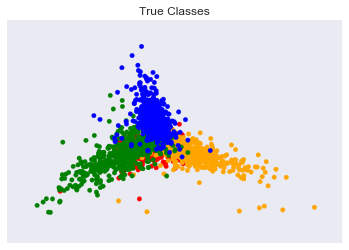

In [21]:
plt.figure(1)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [22]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

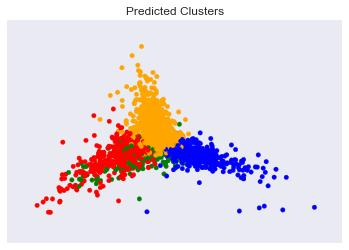

In [23]:
plt.figure(1)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters')
plt.show()

Let's try with 3 clusters.

In [24]:
km3 = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [25]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

# Hierarchical Clustering

Instead of looking at the matrix of documents to words, we can instead look at how the documents relate to each other.

To do this we will take our matrix of word counts per document `newsgroupsTFVects` and create a word occurrence matrix measuring how similar the documents are to each other based on their number of shared words.

In [26]:

newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


/usr/local/lib/python3.5/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Now we can comute the linkage between the different texts, creating a tree. Although due to time considerations we will only look at the first 100 texts.

In [27]:
linkage_matrix = scipy.cluster.hierarchy.ward(newsgroupsCoocMat[:100, :100].toarray())
linkage_matrix[:10]

array([[  3.00000000e+00,   2.60000000e+01,   0.00000000e+00,
          2.00000000e+00],
       [  5.20000000e+01,   1.00000000e+02,   0.00000000e+00,
          3.00000000e+00],
       [  6.80000000e+01,   1.01000000e+02,   0.00000000e+00,
          4.00000000e+00],
       [  7.50000000e+01,   1.02000000e+02,   0.00000000e+00,
          5.00000000e+00],
       [  7.60000000e+01,   1.03000000e+02,   0.00000000e+00,
          6.00000000e+00],
       [  8.20000000e+01,   1.04000000e+02,   0.00000000e+00,
          7.00000000e+00],
       [  9.90000000e+01,   1.05000000e+02,   0.00000000e+00,
          8.00000000e+00],
       [  7.10000000e+01,   1.06000000e+02,   9.01006985e-02,
          9.00000000e+00],
       [  6.30000000e+01,   1.07000000e+02,   1.37599835e-01,
          1.00000000e+01],
       [  9.70000000e+01,   1.08000000e+02,   1.62125902e-01,
          1.10000000e+01]])

Now we can visualize the tree

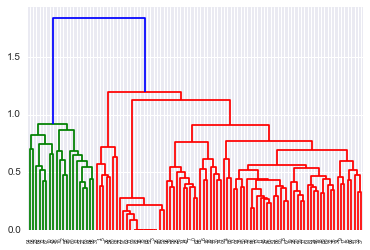

In [28]:
ax = scipy.cluster.hierarchy.dendrogram(linkage_matrix)

This plot is somewhat unwieldy, to make it easier to read we can cut the tree after a number of branches and then just show a central leaf.

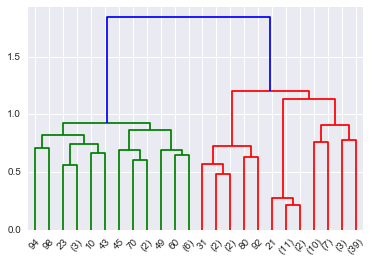

In [29]:
ax = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level')

By default the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but their are other ways of forming clusters.


One of the most common is to cut the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters

In [30]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([4, 2, 1, 3, 4, 2, 4, 4, 4, 4, 1, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4,
       1, 4, 4, 3, 1, 4, 4, 4, 2, 4, 4, 4, 4, 2, 4, 4, 4, 3, 4, 4, 1, 4, 1,
       4, 4, 4, 1, 4, 4, 3, 3, 2, 4, 4, 1, 1, 4, 1, 4, 4, 3, 1, 4, 4, 4, 3,
       4, 1, 3, 1, 4, 4, 3, 3, 4, 4, 4, 2, 4, 3, 1, 1, 4, 4, 1, 4, 4, 4, 4,
       2, 4, 1, 1, 4, 3, 1, 3], dtype=int32)

This gives us an array giving each element of `linkage_matrix`'s cluster. We can save this, plot it or look for the representative examples from the clusters.

In [31]:
clusterLeaders = scipy.cluster.hierarchy.leaders(linkage_matrix, hierarchicalClusters)
clusterLeaders

(array([117, 194, 188, 195], dtype=int32), array([3, 4, 2, 1], dtype=int32))

We can then look these up in our original data

In [32]:
newsgroupsDF.iloc[clusterLeaders[0]]

,category,source_file,text
117,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,Are there any PDS expansion cards out there th...
194,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,Here is the story:\nI have a network with 4 Ma...
188,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,I just hooked up my Mac IIsi to a relatively o...
195,comp.sys.mac.hardware,/Users/Reid/scikit_learn_data/20news_home/20ne...,Hi all:\nDoes anyone know where I can get the ...


# Gensim

To do topic modeling we will again be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). Lets start by defining the same function as last lesson and loading a few press releases from Obama into a DataFrame.

In [33]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)

    #Check for rate limiting
    if r.status_code != 200:
        raise RuntimeError("Github didn't like your request, you have probably been rate limited.")
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

obReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Obama', maxFiles = 20)
obReleases[:5]

,download_url,html_url,name,path,text
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...


Now we have the files we can tokenize and normalize

In [34]:
#Define the same function as last week
def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)

    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)

    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    #We will return a list with the stopwords removed
    return list(workingIter)

#initialize our stemmer and our stop words
stop_words_nltk = nltk.corpus.stopwords.words('english')
snowball = nltk.stem.snowball.SnowballStemmer('english')

#Apply our functions
obReleases['tokenized_text'] = obReleases['text'].apply(lambda x: nltk.word_tokenize(x))
obReleases['normalized_tokens'] = obReleases['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))

To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictioanry` that maps tokens to ids.

In [35]:
dictionary = gensim.corpora.Dictionary(obReleases['normalized_tokens'])

Then for each of the texts we create a list of tuples containing: each token and its count. We will only use the first half of our dataset for now, and will leave the second half to test with.

In [36]:
corpus = [dictionary.doc2bow(text) for text in obReleases['normalized_tokens'][:10]]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [37]:
gensim.corpora.MmCorpus.serialize('obama.mm', corpus)
obmm = gensim.corpora.MmCorpus('obama.mm')

Now we have a correctly formatted corpura that we can use for some topic models

In [38]:
oblda = gensim.models.ldamodel.LdaModel(corpus=obmm, id2word=dictionary, num_topics=10)

We can check how well different texts belong to different topics, heres one of the texts from the training set

In [39]:
ob1Bow = dictionary.doc2bow(obReleases['normalized_tokens'][0])
ob1lda = oblda[ob1Bow]
ob1lda

[(5, 0.99769791815383835)]

and one from the withheld set

In [40]:
ob11Bow = dictionary.doc2bow(obReleases['normalized_tokens'][11])
ob11lda = oblda[ob1Bow]
ob11lda

[(5, 0.99769792329151252)]